# **ELE-670-Medical-Imaging-with-AI-Integration-Project-Rousseau-Bastien**

## Imports of libraries 

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import PurePosixPath as PPP
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b0,efficientnet_b1, EfficientNet_B0_Weights, EfficientNet_B1_Weights
from PIL import Image
from tqdm import tqdm  
import torch.nn.functional as F
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, classification_report


## Reading and cleaning metadata

In [ ]:
df_dicom = pd.read_csv("/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv")
df_train = pd.read_csv("/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv")
df_test  = pd.read_csv("/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_test_set.csv")

#Remove useless data for the project 
drop_cols = [
    'cropped image file path','ROI mask file path','image view',
    'assessment','calc distribution','abnormality id',
    'left or right breast','breast density','patient_id',
    'abnormality type','calc type','subtlety'
]
df_train_clean = df_train.drop(columns=drop_cols)
df_test_clean  = df_test.drop(columns=drop_cols)


df_train_clean["ID"] = df_train_clean["image file path"].str.extract(r'(\d+(?:\.\d+)+)')
df_test_clean["ID"]  = df_test_clean["image file path"].str.extract(r'(\d+(?:\.\d+)+)')


df_dicom = df_dicom.rename(columns={"StudyInstanceUID": "ID"})


df_train_with_path = df_train_clean.merge(
    df_dicom[["ID","image_path"]],
    on="ID", how="left"
)
df_test_with_path = df_test_clean.merge(
    df_dicom[["ID","image_path"]],
    on="ID", how="left"
)

#Merging the image path with the pathology
df_train_with_path["image file path"] = df_train_with_path["image_path"].fillna(df_train_with_path["image_path"])
df_test_with_path["image file path"]  = df_test_with_path["image_path"].fillna(df_test_with_path["image_path"])

df_train_with_path["image file path"] = df_train_with_path["image file path"].apply(lambda x: x.split("CBIS-DDSM/")[-1])
df_test_with_path["image file path"]  = df_test_with_path["image file path"].apply(lambda x: x.split("CBIS-DDSM/")[-1])

base_dir = "/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/"


df_train_with_path["image file path"] = df_train_with_path["image file path"].apply(
    lambda x: base_dir + x.split("CBIS-DDSM/")[-1]
)
df_test_with_path["image file path"] = df_test_with_path["image file path"].apply(
    lambda x: base_dir + x.split("CBIS-DDSM/")[-1]
)



df_train_final = df_train_with_path
df_test_final  = df_test_with_path

drop_cols1 = ["ID","image_path"]
df_train_final = df_train_with_path.drop(columns=drop_cols1)
df_test_final = df_test_with_path.drop(columns=drop_cols1)
df_test_final.head()

,pathology,image file path
0,BENIGN,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
1,BENIGN,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
2,BENIGN_WITHOUT_CALLBACK,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
3,BENIGN_WITHOUT_CALLBACK,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
4,BENIGN_WITHOUT_CALLBACK,/kaggle/input/cbis-ddsm-breast-cancer-image-da...


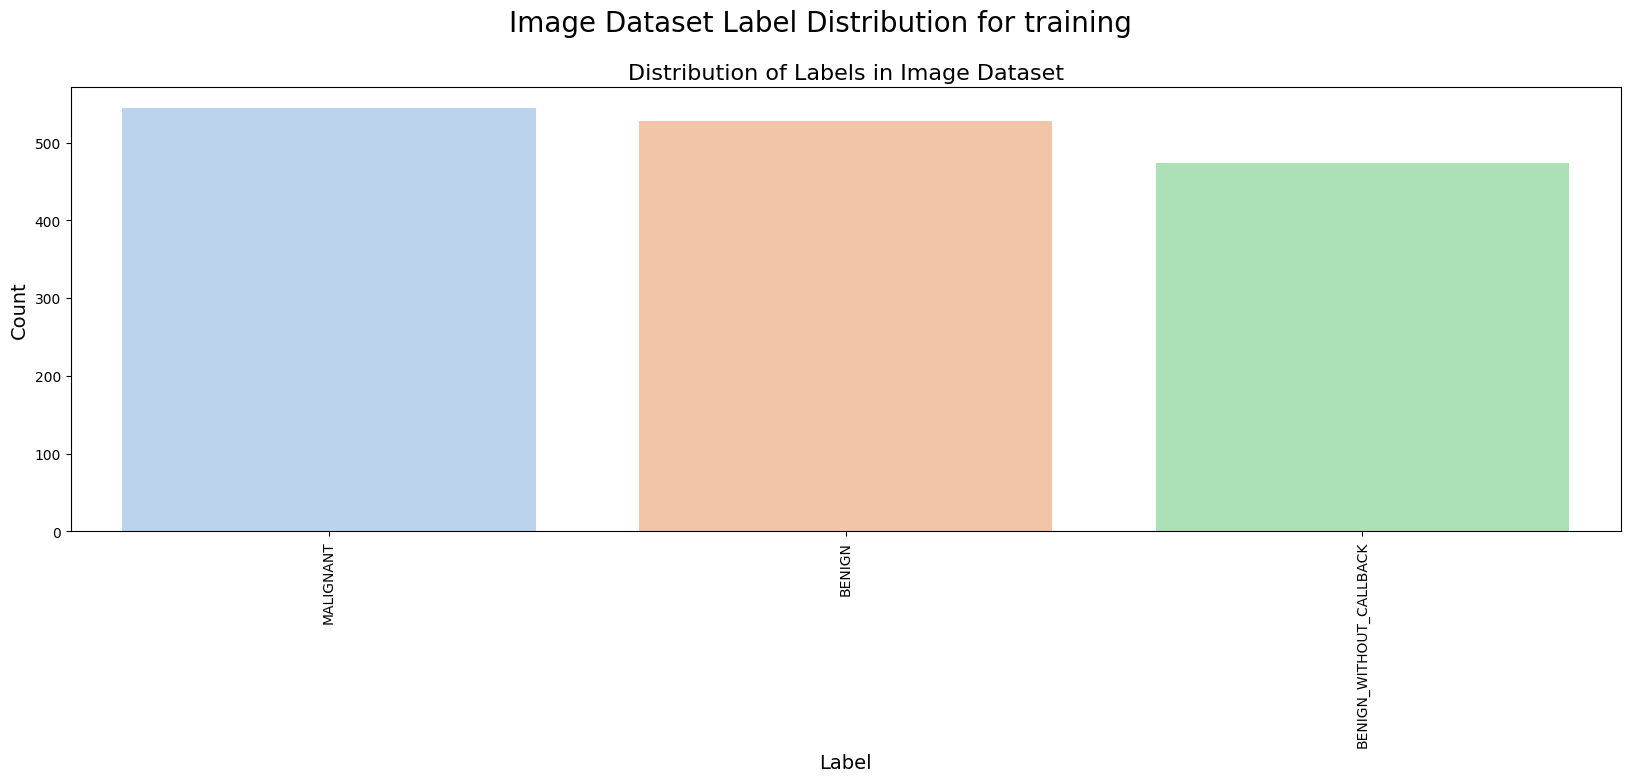

Number of images per category : 
pathology
MALIGNANT                  544
BENIGN                     528
BENIGN_WITHOUT_CALLBACK    474
Name: count, dtype: int64


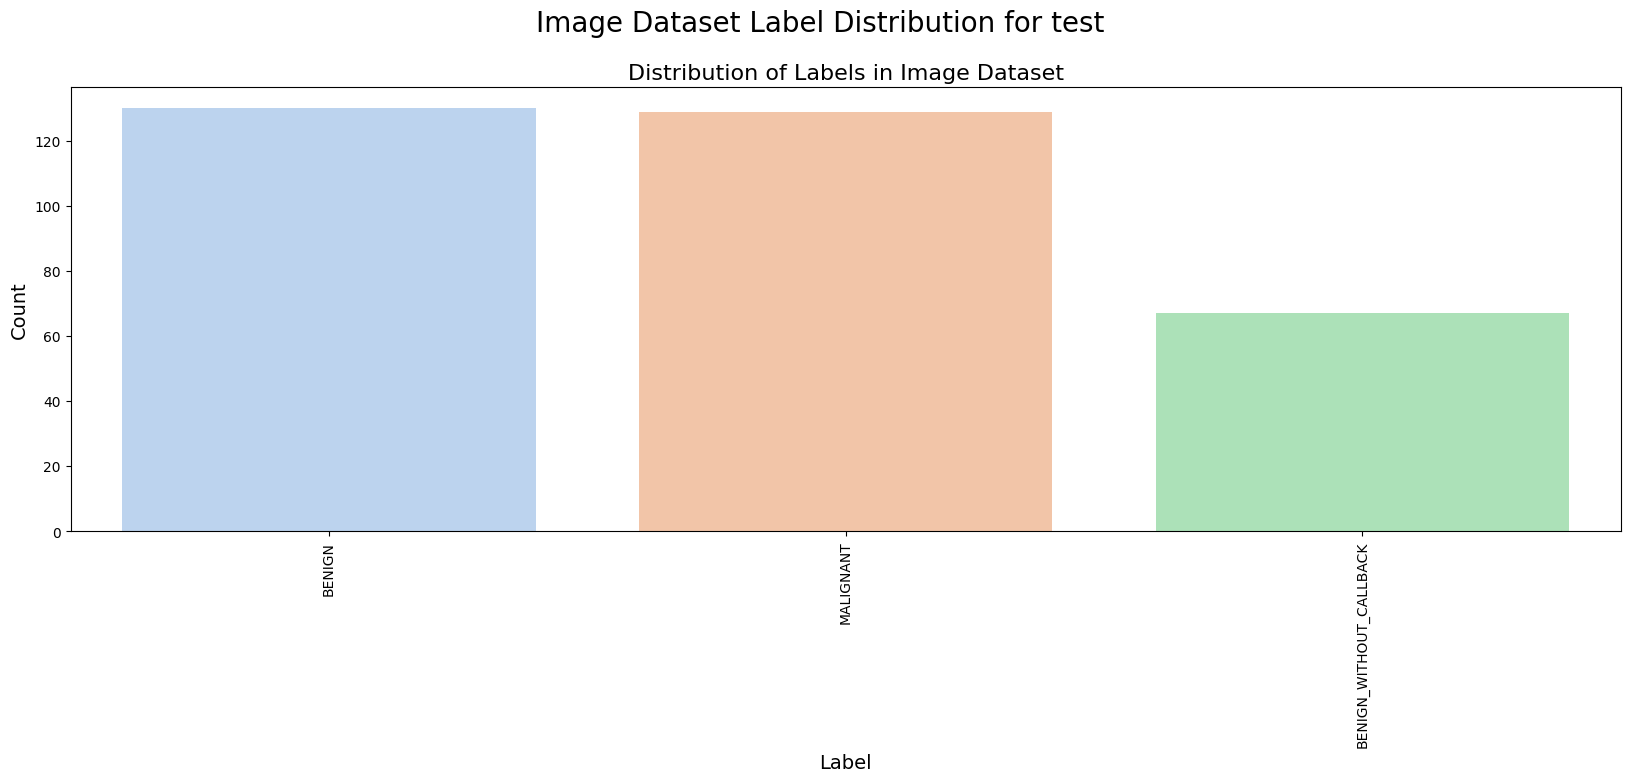

Number of images per category in test : 
pathology
BENIGN                     130
MALIGNANT                  129
BENIGN_WITHOUT_CALLBACK     67
Name: count, dtype: int64


In [ ]:
# Visualization of the data

label_counts_1 = df_train_final['pathology'].value_counts() 


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

sns.barplot(x=label_counts_1.index, y=label_counts_1, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts_1.index, rotation=90)


fig.suptitle('Image Dataset Label Distribution for training', fontsize=20)


fig.subplots_adjust(top=0.85)


plt.show()

print("Number of images per category : ")
print(label_counts_1)

label_counts = df_test_final['pathology'].value_counts() 


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

sns.barplot(x=label_counts.index, y=label_counts, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=90)


fig.suptitle('Image Dataset Label Distribution for test', fontsize=20)


fig.subplots_adjust(top=0.85)


plt.show()

print("Number of images per category in test : ")
print(label_counts)

In [ ]:
#Changing the pathology to category

label_mapping = {"BENIGN": 0, "MALIGNANT": 1, "BENIGN_WITHOUT_CALLBACK": 2}


df_train_final['pathology'] =  df_train_clean['pathology'].map(label_mapping)


df_train_final.sample(n=9, random_state=6)


,pathology,image file path
885,1,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
1058,1,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
168,0,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
1063,1,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
975,2,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
831,1,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
961,0,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
861,2,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
219,0,/kaggle/input/cbis-ddsm-breast-cancer-image-da...


In [ ]:
#Visualization of some images's size
label_mapping = {"BENIGN": 0, "MALIGNANT": 1, "BENIGN_WITHOUT_CALLBACK": 2}
df_test_final['pathology'] =  df_test_clean['pathology'].map(label_mapping)
df_test_final.sample(n=9, random_state=6)
sizes = str("")
for i in range (1,100,10):
    img_path = df_test_final.iloc[i]["image file path"]
    img = Image.open(img_path)
    sizes +="Image "+str(i)+", size : "+str(img.size)+"\n"
print(sizes)

Image 1, size : (3064, 4728)
Image 11, size : (3104, 4544)
Image 21, size : (3056, 4464)
Image 31, size : (3280, 5896)
Image 41, size : (3032, 4528)
Image 51, size : (3976, 6871)
Image 61, size : (3072, 4640)
Image 71, size : (3104, 4392)
Image 81, size : (4056, 6032)
Image 91, size : (3104, 4560)



## Creation of the training dataset

In [7]:
train_df, valid_df = train_test_split(
    df_train_final, 
    train_size=0.8,      
    random_state=42,    
    stratify=df_train_final['pathology']  
)

print("Size of train :", len(train_df))
print("Size of validation :", len(valid_df))

Size of train : 1236
Size of validation : 310


# EfficientNet B1 Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


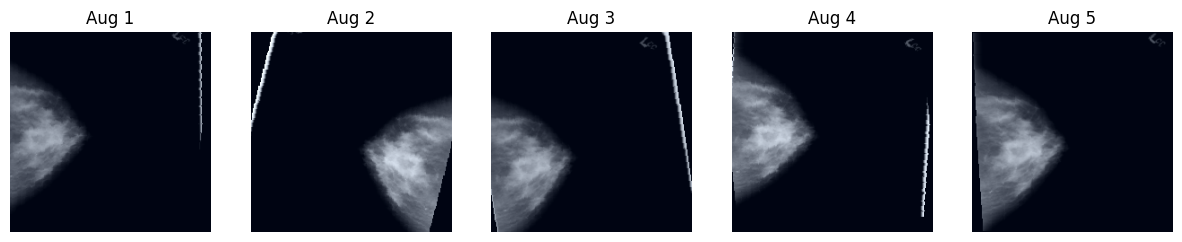

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 139MB/s] 


In [ ]:
class MammographyDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["image file path"]  
        label = self.df.iloc[idx]["pathology"]          
        image = Image.open(img_path).convert("RGB")      
        if self.transform:
            image = self.transform(image)
        
        return image, label

#Transformations for data augmentation
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

#Conversion of dataset for the input
train_dataset = MammographyDataset(train_df, transform=train_transform)
valid_dataset = MammographyDataset(valid_df, transform=valid_transform)
test_dataset  = MammographyDataset(df_test_final, transform=valid_transform)

#Loading the dataset
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)


sample_img, sample_label = train_dataset[0] 
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
plt.title("Example of augmented images")
for i in range(5):
    img, _ = train_dataset[0]  
    axs[i].imshow(img.permute(1, 2, 0).numpy() * 0.229 + 0.485)  
    axs[i].set_title(f"Aug {i+1}")
    axs[i].axis("off")

plt.show()

model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(nn.Dropout(0.6),  nn.Linear(num_ftrs, 3))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


loss_funct = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)

patience = 5
best_val_loss = float("inf")
early_stop_counter = 0

In [ ]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

nb_epochs = 50

for epoch in range(1, nb_epochs + 1):
    # Train
    model.train()
    running_loss, correct, total = 0, 0, 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{nb_epochs} [TRAIN]", leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_funct(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100*correct/total)
    
    train_loss = running_loss / total
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc=f"Epoch {epoch}/{nb_epochs} [VAL]", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_funct(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)
    val_loss /= val_total
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "/kaggle/working/best_model.pth")

    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

  
    print(f"Epoch [{epoch}/{nb_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/50] Train Loss: 1.0790, Train Acc: 41.18% | Val Loss: 0.9882, Val Acc: 52.26%


Epoch [2/50] Train Loss: 0.9828, Train Acc: 52.10% | Val Loss: 0.8894, Val Acc: 57.10%


Epoch [3/50] Train Loss: 0.9254, Train Acc: 54.69% | Val Loss: 0.8573, Val Acc: 55.81%


Epoch [4/50] Train Loss: 0.8843, Train Acc: 56.15% | Val Loss: 0.7846, Val Acc: 63.23%


Epoch [5/50] Train Loss: 0.8373, Train Acc: 59.79% | Val Loss: 0.7461, Val Acc: 66.45%


Epoch [6/50] Train Loss: 0.8025, Train Acc: 59.95% | Val Loss: 0.7490, Val Acc: 64.19%


Epoch [7/50] Train Loss: 0.7710, Train Acc: 64.16% | Val Loss: 0.7334, Val Acc: 64.84%


Epoch [8/50] Train Loss: 0.7529, Train Acc: 65.05% | Val Loss: 0.6894, Val Acc: 70.65%


Epoch [9/50] Train Loss: 0.7440, Train Acc: 65.53% | Val Loss: 0.6480, Val Acc: 69.03%


Epoch [10/50] Train Loss: 0.6957, Train Acc: 67.88% | Val Loss: 0.6643, Val Acc: 69.68%


Epoch [11/50] Train Loss: 0.6886, Train Acc: 67.48% | Val Loss: 0.6336, Val Acc: 69.03%


Epoch [12/50] Train Loss: 0.6304, Train Acc: 70.95% | Val Loss: 0.6231, Val Acc: 72.58%


Epoch [13/50] Train Loss: 0.6097, Train Acc: 73.87% | Val Loss: 0.6232, Val Acc: 73.23%


Epoch [14/50] Train Loss: 0.5731, Train Acc: 74.60% | Val Loss: 0.6445, Val Acc: 72.26%


Epoch [15/50] Train Loss: 0.5780, Train Acc: 75.08% | Val Loss: 0.6032, Val Acc: 71.94%


Epoch [16/50] Train Loss: 0.5315, Train Acc: 78.32% | Val Loss: 0.6540, Val Acc: 72.58%


Epoch [17/50] Train Loss: 0.5137, Train Acc: 78.48% | Val Loss: 0.6324, Val Acc: 70.97%


Epoch [18/50] Train Loss: 0.5016, Train Acc: 79.45% | Val Loss: 0.6780, Val Acc: 70.65%


Epoch [19/50] Train Loss: 0.4615, Train Acc: 80.10% | Val Loss: 0.7128, Val Acc: 70.65%


Early stopping triggered.


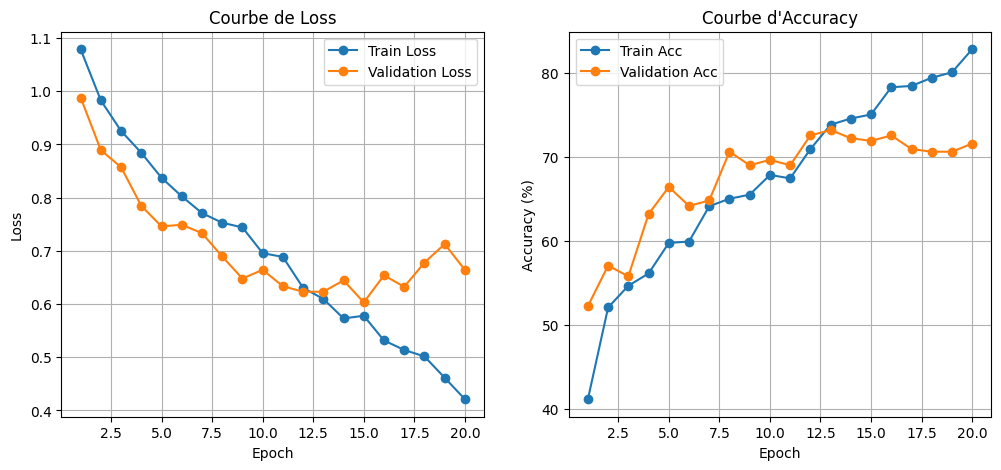

In [32]:
plt.figure(figsize=(12,5))
# Loss
plt.subplot(1,2,1)
plt.plot(range(1,len(train_losses)+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1,len(val_losses)+1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Courbe de Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(range(1,len(train_accs)+1), train_accs, label='Train Acc', marker='o')
plt.plot(range(1,len(val_accs)+1), val_accs, label='Validation Acc', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Courbe d\'Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Visualization of some images with their predicted and true label
label_mapping = {0: "BENIGN", 1: "MALIGNANT", 2: "BENIGN_WO_CALLBACK"}
model.eval()
examples = 12  

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        break  

n = min(examples, images.size(0))

plt.figure(figsize=(15, 6))
for i in range(n):
    img = images[i].cpu().permute(1, 2, 0) 
    true_label = labels[i].item()
    pred_label = preds[i].item()
    
    plt.subplot(2, n//2, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"True: {label_mapping[true_label]} Pred: {label_mapping[pred_label]}",
              fontsize=8, color="green" if true_label==pred_label else "red")
    plt.axis("off")

plt.tight_layout()
plt.show()

=== Confusion Matrix (raw values) ===
[[57 52 21]
 [37 76 16]
 [ 9  4 54]]

=== Normalized Confusion Matrix ===
[[0.44 0.4  0.16]
 [0.29 0.59 0.12]
 [0.13 0.06 0.81]]


<Figure size 600x600 with 0 Axes>

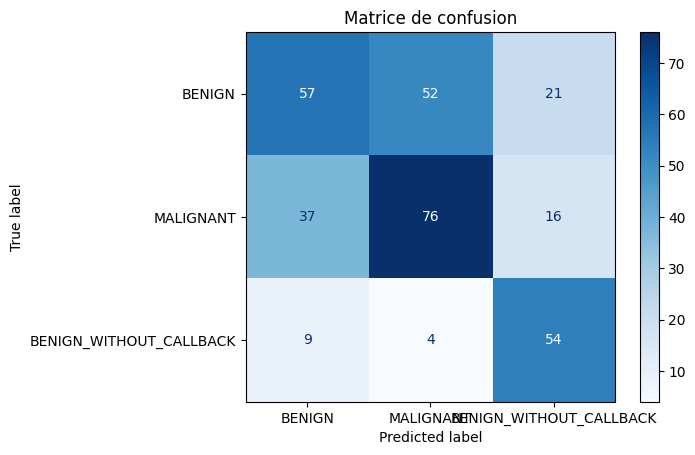

In [ ]:
all_preds = []
all_labels = []
model.eval()

with torch.no_grad():
    for img, labels in test_loader:
        img, labels = img.to(device), labels.to(device)
        outputs = model(img)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))

print("=== Confusion Matrix (raw values) ===")
print(cm)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
print("=== Normalized Confusion Matrix ===")
np.set_printoptions(precision=2, suppress=True)
print(cm_norm)


fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot(ax=ax, cmap="Blues", values_format='d', colorbar=False)
plt.title("Matrice de confusion")
plt.show()


In [ ]:
cm = np.array([
   [57 ,52, 21],
 [37 ,76, 16],
 [ 9  ,4, 54]
])
class_names = ["BENIGN", "MALIGNANT", "BENIGN_WITHOUT_CALLBACK"]
y_true = []
y_pred = []

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        y_true += [i] * cm[i, j]
        y_pred += [j] * cm[i, j]

y_true = np.array(y_true)
y_pred = np.array(y_pred)


precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)
accuracy = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")
weighted_f1 = f1_score(y_true, y_pred, average="weighted")

print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))
print(f"Global Accuracy: {accuracy:.3f}")
print(f"Macro F1-score: {macro_f1:.3f}")
print(f"Weighted F1-score: {weighted_f1:.3f}")


try:
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
    y_pred_bin = label_binarize(y_pred, classes=list(range(len(class_names))))
    auc = roc_auc_score(y_true_bin, y_pred_bin, average=None, multi_class="ovr")
    print("=== AUC per class ===")
    for i, cls in enumerate(class_names):
        print(f"{cls}: {auc[i]:.3f}")
except Exception as e:
    print("AUC could not be computed:", e)



=== CLASSIFICATION REPORT ===
                         precision    recall  f1-score   support

                 BENIGN      0.553     0.438     0.489       130
              MALIGNANT      0.576     0.589     0.582       129
BENIGN_WITHOUT_CALLBACK      0.593     0.806     0.684        67

               accuracy                          0.574       326
              macro avg      0.574     0.611     0.585       326
           weighted avg      0.570     0.574     0.566       326

Global Accuracy: 0.574
Macro F1-score: 0.585
Weighted F1-score: 0.566

=== AUC per class ===
BENIGN: 0.602
MALIGNANT: 0.652
BENIGN_WITHOUT_CALLBACK: 0.832


=== Confusion Matrix (raw values) ===
[[373  39  10]
 [ 20 408   7]
 [ 10   8 361]]

=== Normalized Confusion Matrix ===
[[0.88 0.09 0.02]
 [0.05 0.94 0.02]
 [0.03 0.02 0.95]]


<Figure size 600x600 with 0 Axes>

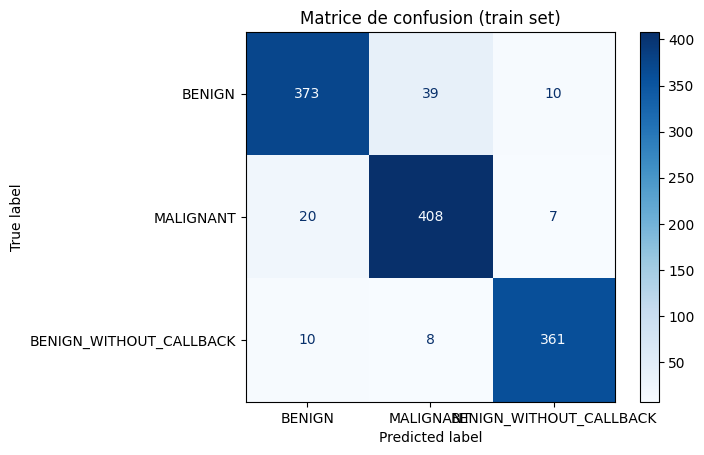

In [ ]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))


print("=== Confusion Matrix (raw values) ===")
print(cm)


cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
np.set_printoptions(precision=2, suppress=True)
print("=== Normalized Confusion Matrix ===")
print(cm_norm)


plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format='d')
plt.title("Matrice de confusion (train set)")
plt.show()


## ViT Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nb_epochs = 25
batch_size = 16
num_classes = 3
patience = 5

label_mapping = {"BENIGN": 0, "MALIGNANT": 1, "BENIGN_WITHOUT_CALLBACK": 2}
weights = ViT_B_16_Weights.IMAGENET1K_V1
#Transformation for data augmentation
train_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomResizedCrop(384, scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2),
    transforms.RandomAdjustSharpness(1.5, p=0.3),
    transforms.RandomAutocontrast(p=0.2),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
])

valid_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
])



class_weights_df = train_df["pathology"].map({
    "BENIGN": 1.0,
    "MALIGNANT": 1.5,
    "BENIGN_WITHOUT_CALLBACK": 1.0
})
class_weights_df = class_weights_df.fillna(1.0)
class_weights_df[class_weights_df < 0] = 1.0
sample_weights = torch.tensor(class_weights_df.values, dtype=torch.float)


sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
#Loading of dataset for the input
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

#Loading the weights of the model
vit = vit_b_16(weights=weights)
in_feats = vit.heads.head.in_features
vit.heads.head = nn.Linear(in_feats, num_classes)
model = vit.to(device)

#Reduce small imbalance between classes
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        return ((1 - pt) ** self.gamma * ce_loss).mean()

class_weights = torch.tensor([1.0, 1.5, 1.0]).to(device)
loss_funct = FocalLoss(gamma=2, weight=class_weights)



for p in model.parameters():
    p.requires_grad = False
for p in model.heads.parameters():
    p.requires_grad = True

optimizer = torch.optim.AdamW(model.heads.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
best_val_loss = float("inf")
early_stop_counter = 0

Training head of ViT



Epoch [1/25] | Train 0.672/34.87% | Val 0.667/37.74%



Epoch [2/25] | Train 0.619/41.34% | Val 0.626/40.97%



Epoch [3/25] | Train 0.593/43.12% | Val 0.607/45.48%



Epoch [4/25] | Train 0.572/43.69% | Val 0.602/49.35%



Epoch [5/25] | Train 0.569/43.28% | Val 0.585/47.74%



Epoch [6/25] | Train 0.552/48.62% | Val 0.575/50.65%



Epoch [7/25] | Train 0.542/48.71% | Val 0.566/48.06%



Epoch [8/25] | Train 0.535/48.54% | Val 0.566/51.29%



Epoch [9/25] | Train 0.558/45.47% | Val 0.564/50.97%



Epoch [10/25] | Train 0.539/47.25% | Val 0.564/50.97%



Epoch [11/25] | Train 0.538/45.87% | Val 0.564/50.97%



Epoch [12/25] | Train 0.547/46.44% | Val 0.563/50.97%



Epoch [13/25] | Train 0.541/43.77% | Val 0.565/51.94%



Epoch [14/25] | Train 0.537/48.46% | Val 0.562/51.29%



Epoch [15/25] | Train 0.533/49.27% | Val 0.556/51.94%



Epoch [16/25] | Train 0.545/48.06% | Val 0.554/52.90%



Epoch [17/25] | Train 0.525/48.54% | Val 0.547/52.58%



Epoch [18/25] | Train 0.538/48.22% | Val 0.554/56.13%



Epoch [19/25] | Train 0.533/50.00% | Val 0.554/54.52%



Epoch [20/25] | Train 0.514/50.73% | Val 0.539/56.13%



Epoch [21/25] | Train 0.504/52.51% | Val 0.523/53.87%



Epoch [22/25] | Train 0.510/51.86% | Val 0.532/55.48%



Epoch [23/25] | Train 0.515/50.40% | Val 0.533/59.35%



Epoch [24/25] | Train 0.508/51.38% | Val 0.514/52.58%



Epoch [25/25] | Train 0.508/54.21% | Val 0.510/50.32%


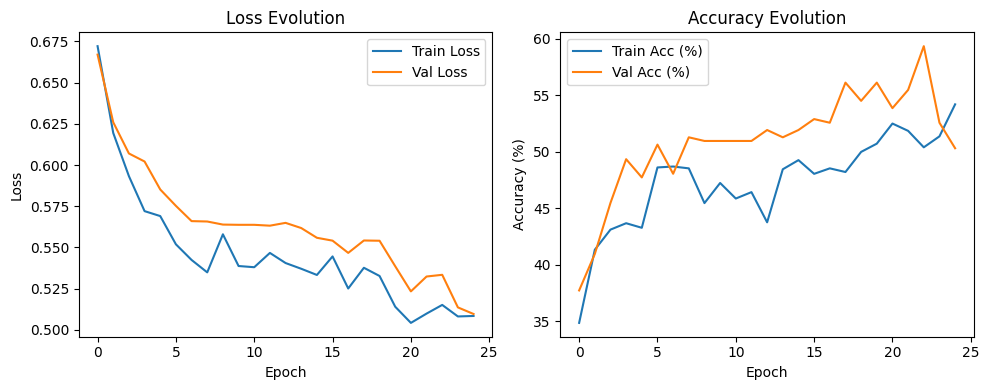

Fine tuning



Fine-tune Epoch [1/10] | Train 0.513/54.77% | Val 0.458/58.39%



Fine-tune Epoch [2/10] | Train 0.455/59.06% | Val 0.425/58.06%



Fine-tune Epoch [3/10] | Train 0.413/59.87% | Val 0.402/61.94%



Fine-tune Epoch [4/10] | Train 0.397/63.51% | Val 0.466/57.10%



Fine-tune Epoch [5/10] | Train 0.398/61.33% | Val 0.438/59.03%



Fine-tune Epoch [6/10] | Train 0.373/65.13% | Val 0.385/63.87%



Fine-tune Epoch [7/10] | Train 0.319/68.69% | Val 0.371/63.55%



Fine-tune Epoch [8/10] | Train 0.305/70.95% | Val 0.375/62.58%



Fine-tune Epoch [9/10] | Train 0.300/70.79% | Val 0.365/61.29%



Fine-tune Epoch [10/10] | Train 0.277/72.73% | Val 0.360/61.29%


In [ ]:
#Training
train_losses, val_losses = [], []
train_accs, val_accs = [], []

nb_epochs = 50
for epoch in range(1, nb_epochs + 1):
    model.train()
    running_loss, correct, total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{nb_epochs} [TRAIN]", leave=False)

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_funct(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    train_loss = running_loss / total
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for imgs, labels in tqdm(valid_loader, desc=f"Epoch {epoch}/{nb_epochs} [VAL]", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = loss_funct(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())

    val_loss /= val_total
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch}/{nb_epochs}] | Train {train_loss:.3f}/{train_acc:.2f}% | Val {val_loss:.3f}/{val_acc:.2f}%")

    scheduler.step()

    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "/kaggle/working/best_vit_head.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss Evolution")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc (%)")
plt.plot(val_accs, label="Val Acc (%)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.legend(); plt.title("Accuracy Evolution")
plt.tight_layout()
plt.show()

print("Fine tuning")
for blk in model.encoder.layers[-3:]:
    for p in blk.parameters():
        p.requires_grad = True
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),lr=5e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

model.load_state_dict(torch.load("/kaggle/working/best_vit_finetuning.pth"))
best_val_loss = float("inf")
early_stop_counter = 0

for epoch in range(1, 11):
    model.train()
    running_loss, correct, total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Fine-tuning Epoch {epoch}/10", leave=False)

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_funct(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for imgs, labels in valid_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = loss_funct(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())

    val_loss /= val_total
    val_acc = 100 * val_correct / val_total
    print(f"Fine-tune Epoch [{epoch}/10] | Train {train_loss:.3f}/{train_acc:.2f}% | Val {val_loss:.3f}/{val_acc:.2f}%")

    scheduler.step()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "/kaggle/working/best_vit.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            break




=== Confusion Matrix (raw values) ===
[[44 78  8]
 [28 99  2]
 [ 9 25 33]]

=== Normalized Confusion Matrix ===
[[0.34 0.6  0.06]
 [0.22 0.77 0.02]
 [0.13 0.37 0.49]]


<Figure size 600x600 with 0 Axes>

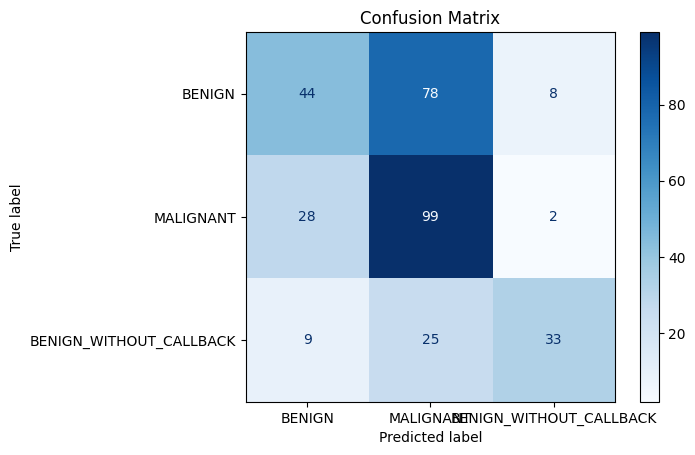

In [16]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))


print("=== Confusion Matrix (raw values) ===")
print(cm)


cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
print("=== Normalized Confusion Matrix ===")
np.set_printoptions(precision=2, suppress=True)
print(cm_norm)


plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [19]:
cm = np.array([
   [44 ,78,  8],
 [28 ,99  ,2],
 [ 9 ,25, 33]])

class_names = ["BENIGN", "MALIGNANT", "BENIGN_WITHOUT_CALLBACK"]


y_true = []
y_pred = []

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        y_true += [i] * cm[i, j]
        y_pred += [j] * cm[i, j]

y_true = np.array(y_true)
y_pred = np.array(y_pred)


precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)
accuracy = accuracy_score(y_true, y_pred)


macro_f1 = f1_score(y_true, y_pred, average="macro")
weighted_f1 = f1_score(y_true, y_pred, average="weighted")

print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))
print(f"Global Accuracy: {accuracy:.3f}")
print(f"Macro F1-score: {macro_f1:.3f}")
print(f"Weighted F1-score: {weighted_f1:.3f}")


try:
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
    y_pred_bin = label_binarize(y_pred, classes=list(range(len(class_names))))
    auc = roc_auc_score(y_true_bin, y_pred_bin, average=None, multi_class="ovr")
    print("=== AUC per class ===")
    for i, cls in enumerate(class_names):
        print(f"{cls}: {auc[i]:.3f}")

except Exception as e:
    print("AUC could not be computed:", e)



=== CLASSIFICATION REPORT ===
                         precision    recall  f1-score   support

                 BENIGN      0.543     0.338     0.417       130
              MALIGNANT      0.490     0.767     0.598       129
BENIGN_WITHOUT_CALLBACK      0.767     0.493     0.600        67

               accuracy                          0.540       326
              macro avg      0.600     0.533     0.538       326
           weighted avg      0.568     0.540     0.526       326

Global Accuracy: 0.540
Macro F1-score: 0.538
Weighted F1-score: 0.526

=== AUC per class ===
BENIGN: 0.575
MALIGNANT: 0.622
BENIGN_WITHOUT_CALLBACK: 0.727


# Merging of Benign and Benign without callback

In [ ]:
label_mapping_binary = {
    "BENIGN": 1,
    "MALIGNANT": 0,
    "BENIGN_WITHOUT_CALLBACK": 1
}

# apply mapping to binary
df_train_final["pathology"] = df_train_clean["pathology"].map(label_mapping_binary)


df_train_final = df_train_final.dropna(subset=["pathology"])


df_train_final["pathology"] = df_train_final["pathology"].astype(int)


print("Classes :", df_train_final["pathology"].unique())
print("Distribution :", df_train_final["pathology"].value_counts())


Classes : [0 1]
Distribution : pathology
1    1002
0     544
Name: count, dtype: int64


In [10]:
train_df, valid_df = train_test_split(
    df_train_final, 
    train_size=0.8,      
    random_state=42,    
    stratify=df_train_final['pathology']  
)

print("Size of train :", len(train_df))
print("Size of validation :", len(valid_df))

Size of train : 1236
Size of validation : 310


In [ ]:
label_mapping_binary = {
    0: 1,  
    1: 0,  
    2: 1   
}

df_test_final["pathology"] = df_test_final["pathology"].map(label_mapping_binary)
df_test_final = df_test_final.dropna(subset=["pathology"]).astype({"pathology": int})

print("Test set classes after merge:", df_test_final["pathology"].unique())
print(df_test_final["pathology"].value_counts())

test_dataset = MammographyDataset(df_test_final, transform=valid_transform)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

Test set classes after merge: [1 0]
pathology
1    197
0    129
Name: count, dtype: int64


'\nlabels_check = []\nfor _, labels in test_loader:\n    labels_check.extend(labels.numpy())\nprint("Unique labels in reloaded test_loader:", np.unique(labels_check))\n'

Class counts: {0: 435, 1: 801}
Class weights: tensor([0.0023, 0.0012])


Epoch [1/50] Train Loss: 0.8689, Train Acc: 58.90% | Val Loss: 0.8013, Val Acc: 83.33%


Epoch [2/50] Train Loss: 0.8325, Train Acc: 60.28% | Val Loss: 0.6063, Val Acc: 66.67%


Epoch [3/50] Train Loss: 0.7740, Train Acc: 66.75% | Val Loss: 0.7354, Val Acc: 66.67%


Epoch [4/50] Train Loss: 0.7822, Train Acc: 65.13% | Val Loss: 0.5282, Val Acc: 66.67%


Epoch [5/50] Train Loss: 0.7323, Train Acc: 69.50% | Val Loss: 0.5060, Val Acc: 66.67%


Epoch [6/50] Train Loss: 0.7211, Train Acc: 72.25% | Val Loss: 0.5035, Val Acc: 100.00%


Epoch [7/50] Train Loss: 0.6872, Train Acc: 72.82% | Val Loss: 0.4983, Val Acc: 83.33%


Epoch [8/50] Train Loss: 0.6694, Train Acc: 74.60% | Val Loss: 0.4181, Val Acc: 83.33%


Epoch [9/50] Train Loss: 0.6248, Train Acc: 77.75% | Val Loss: 0.2873, Val Acc: 83.33%


Epoch [10/50] Train Loss: 0.6559, Train Acc: 75.24% | Val Loss: 0.4196, Val Acc: 83.33%


Epoch [11/50] Train Loss: 0.5733, Train Acc: 79.53% | Val Loss: 0.2517, Val Acc: 100.00%


Epoch [12/50] Train Loss: 0.5607, Train Acc: 79.61% | Val Loss: 0.3716, Val Acc: 83.33%


Epoch [13/50] Train Loss: 0.4981, Train Acc: 82.52% | Val Loss: 0.2242, Val Acc: 100.00%


Epoch [14/50] Train Loss: 0.4895, Train Acc: 83.33% | Val Loss: 0.3171, Val Acc: 100.00%


Epoch [15/50] Train Loss: 0.5215, Train Acc: 81.55% | Val Loss: 0.3184, Val Acc: 100.00%


Epoch [16/50] Train Loss: 0.4426, Train Acc: 85.92% | Val Loss: 0.2751, Val Acc: 100.00%


Epoch [17/50] Train Loss: 0.4528, Train Acc: 85.11% | Val Loss: 0.4078, Val Acc: 83.33%


Early stopping triggered.


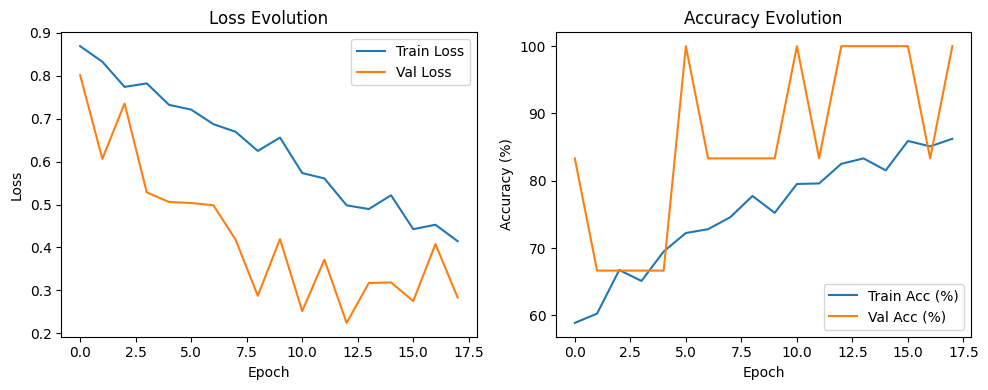

In [ ]:
#Transformation for data augmentation
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])
 
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

#Conversion of dataset for input of the network
train_dataset = MammographyDataset(train_df, transform=train_transform)
valid_dataset = MammographyDataset(valid_df, transform=valid_transform)
test_dataset = MammographyDataset(df_test_final, transform=valid_transform)

#Reducing class imbalance
class_counts = train_df["pathology"].value_counts().sort_index()
print("Class counts:", class_counts.to_dict())
class_weights = 1. / torch.tensor(class_counts.values, dtype=torch.float)
print("Class weights:", class_weights)
sample_weights = [class_weights[int(label)] for label in train_df["pathology"]]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

#Loading the dataset converted
train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)



model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(nn.Dropout(0.6),nn.Linear(num_ftrs, 1) )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
n_major, n_minor = 1002, 544
pos_weight = torch.tensor([n_major / n_minor]).to(device)

loss_funct = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)


patience = 5
best_val_loss = float("inf")
early_stop_counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []
nb_epochs = 50


for epoch in range(1, nb_epochs + 1):
    # training
    model.train()
    running_loss, correct, total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{nb_epochs} [TRAIN]", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1) 
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).long()
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    train_loss = running_loss / total
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    #Validation
    val_loss, val_correct, val_total = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc=f"Epoch {epoch}/{nb_epochs} [VAL]", leave=False):
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = loss(outputs, labels)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long()

    val_loss += loss.item() * images.size(0)
    val_correct += preds.eq(labels.long()).sum().item()
    val_total += labels.size(0)


    val_loss /= val_total
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    scheduler.step(val_loss)


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(),"/kaggle/working/best_model_merge_benignwocallbacks_benign.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

    print(f"Epoch [{epoch}/{nb_epochs}] "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss Evolution")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc (%)")
plt.plot(val_accs, label="Val Acc (%)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.legend(); plt.title("Accuracy Evolution")

plt.tight_layout()
plt.show()

Evaluating on Test Set: 100%|██████████| 41/41 [00:56<00:00,  1.39s/it]


<Figure size 500x500 with 0 Axes>

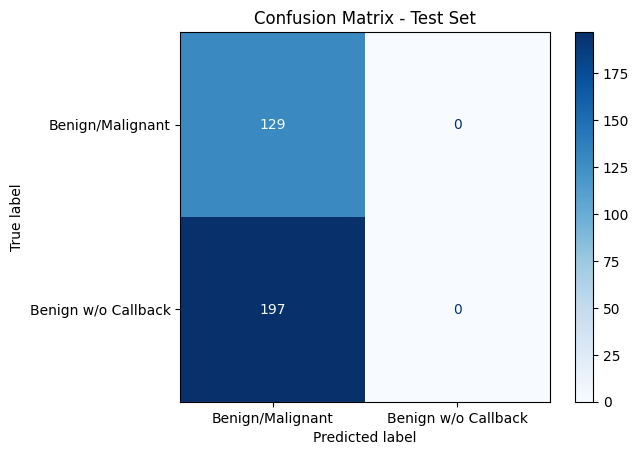

Confusion Matrix
[[129   0]
 [197   0]]
Normalized Confusion Matrix
[[1. 0.]
 [1. 0.]]
Classification Report
                            precision    recall  f1-score   support

Benign/Benign w/o Callback      0.396     1.000     0.567       129
                 Malignant      0.000     0.000     0.000       197

                  accuracy                          0.396       326
                 macro avg      0.198     0.500     0.284       326
              weighted avg      0.157     0.396     0.224       326



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
best_model_path = "/kaggle/working/best_model_merge_benignwocallbacks_benign.pth"
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())


all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)



cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign/Malignant", "Benign w/o Callback"])

plt.figure(figsize=(5, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Test Set")
plt.show()

print("Confusion Matrix")
print(cm)


cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
print("Normalized Confusion Matrix")
np.set_printoptions(precision=2, suppress=True)
print(cm_norm)



print("Classification Report")
print(classification_report(
    all_labels,
    all_preds,
    target_names=["Benign/Benign w/o Callback", "Malignant"],
    digits=3
))




